In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [15]:
batchsize = 64
imagesize = 128

In [16]:
train= tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle = True,
    image_size = (imagesize,imagesize),
    batch_size = batchsize
)
test= tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    shuffle = True,
    image_size = (imagesize,imagesize),
    batch_size =batchsize
)

Found 15557 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.


In [17]:
print(len(train))
print(len(test))

244
63


In [18]:
class_names = train.class_names
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

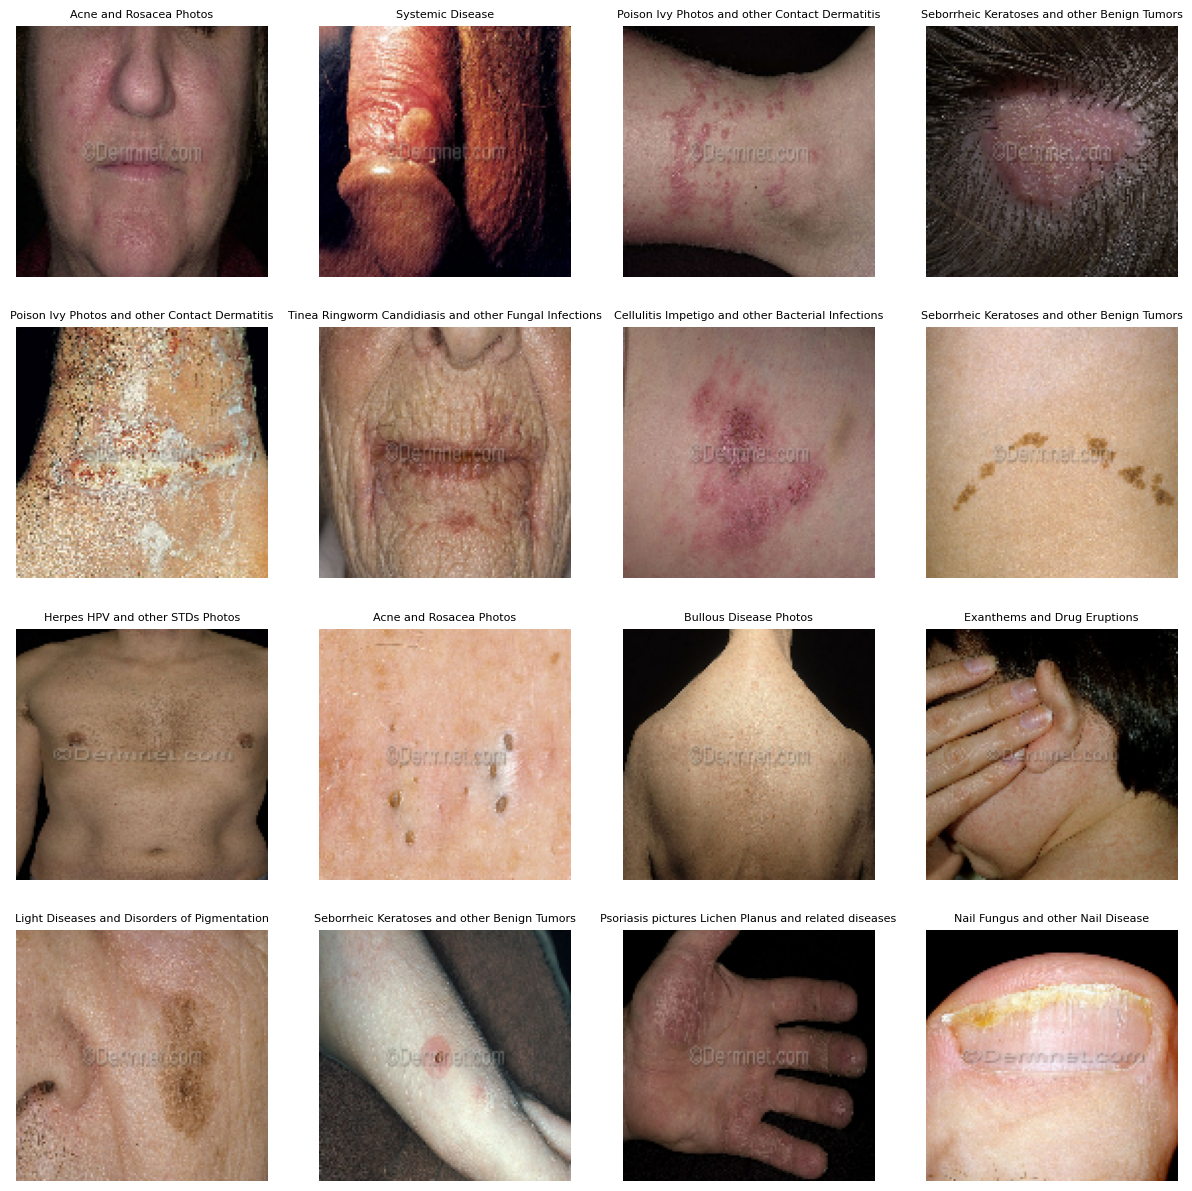

In [21]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train.take(1):
   for j in range(16):
     ax = plt.subplot(4,4,j+1)
     plt.imshow(image_batch[j].numpy().astype("uint8"))
     plt.title(class_names[label_batch[j]],fontsize = 8)
     plt.axis("off")

In [22]:
def dataset_partitions(ds, train_split = 0.9,val_split = 0.1,shuffle = True,shuffle_size =10000):
  assert(train_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 24)
  train_size = int(train_split*ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds

In [23]:
train_ds, val_ds =dataset_partitions(train)

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resizerescale = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(imagesize,imagesize),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
train_ds = train_ds.map(
    lambda x, y: (augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:
model = models.Sequential([
    resizerescale,
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (batchsize,imagesize,imagesize,3) ),
    layers.AveragePooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    layers.AveragePooling2D((2,2)), 
    layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    layers.AveragePooling2D((2,2)),    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(23, activation='softmax'),
    
])
model.build(input_shape = (batchsize,128,128,3))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 128, 128, 3)         0         
                                                                 
 conv2d_94 (Conv2D)          (64, 126, 126, 64)        1792      
                                                                 
 average_pooling2d_9 (Averag  (64, 63, 63, 64)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_95 (Conv2D)          (64, 61, 61, 128)         73856     
                                                                 
 average_pooling2d_10 (Avera  (64, 30, 30, 128)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_96 (Conv2D)          (64, 28, 28, 128)        

In [33]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
epoch =150
history = model.fit(
    train_ds,
    epochs = epoch,
    batch_size = batchsize,
    validation_data = val_ds,
    verbose = 1,
) 

Epoch 1/150
219/219 [==============================] - 290s 1s/step - loss: 2.9831 - accuracy: 0.0960 - val_loss: 2.9132 - val_accuracy: 0.1361
Epoch 2/150
219/219 [==============================] - 2210s 10s/step - loss: 2.8863 - accuracy: 0.1389 - val_loss: 2.8635 - val_accuracy: 0.1458
Epoch 3/150
219/219 [==============================] - 283s 1s/step - loss: 2.8064 - accuracy: 0.1662 - val_loss: 2.8145 - val_accuracy: 0.1673
Epoch 4/150
219/219 [==============================] - 284s 1s/step - loss: 2.7520 - accuracy: 0.1786 - val_loss: 2.6727 - val_accuracy: 0.2044
Epoch 5/150
219/219 [==============================] - 362s 2s/step - loss: 2.7025 - accuracy: 0.1937 - val_loss: 2.6796 - val_accuracy: 0.2031
Epoch 6/150
219/219 [==============================] - 362s 2s/step - loss: 2.6638 - accuracy: 0.2058 - val_loss: 2.6458 - val_accuracy: 0.2096
Epoch 7/150
219/219 [==============================] - 361s 2s/step - loss: 2.6344 - accuracy: 0.2138 - val_loss: 2.5655 - val_accurac

219/219 [==============================] - 270s 1s/step - loss: 1.1658 - accuracy: 0.6281 - val_loss: 1.5495 - val_accuracy: 0.5369
Epoch 114/150
219/219 [==============================] - 270s 1s/step - loss: 1.1555 - accuracy: 0.6306 - val_loss: 1.4216 - val_accuracy: 0.5820
Epoch 115/150
219/219 [==============================] - 269s 1s/step - loss: 1.1522 - accuracy: 0.6251 - val_loss: 1.3080 - val_accuracy: 0.6230
Epoch 116/150
219/219 [==============================] - 270s 1s/step - loss: 1.1195 - accuracy: 0.6423 - val_loss: 1.2869 - val_accuracy: 0.6328
Epoch 117/150
219/219 [==============================] - 271s 1s/step - loss: 1.1152 - accuracy: 0.6428 - val_loss: 1.3683 - val_accuracy: 0.6230
Epoch 118/150
219/219 [==============================] - 269s 1s/step - loss: 1.1323 - accuracy: 0.6383 - val_loss: 1.2602 - val_accuracy: 0.6309
Epoch 119/150
219/219 [==============================] - 270s 1s/step - loss: 1.1083 - accuracy: 0.6439 - val_loss: 1.2855 - val_accuracy:

In [35]:
scores = model.evaluate(test_ds)

63/63 [==============================] - 23s 334ms/step - loss: 3.5893 - accuracy: 0.3286


In [36]:
scores

[3.589268684387207, 0.3285857141017914]

In [37]:
history.history['accuracy']

[0.09596175700426102,
 0.13891267776489258,
 0.16623859107494354,
 0.1785816252231598,
 0.1937071979045868,
 0.20576484501361847,
 0.21375571191310883,
 0.22039097547531128,
 0.232876718044281,
 0.23901255428791046,
 0.24821633100509644,
 0.2558504641056061,
 0.26591038703918457,
 0.26904964447021484,
 0.27475741505622864,
 0.27575626969337463,
 0.2854594886302948,
 0.2905251085758209,
 0.29716038703918457,
 0.31157249212265015,
 0.3125,
 0.31678083539009094,
 0.32213184237480164,
 0.32755422592163086,
 0.3335473835468292,
 0.33411815762519836,
 0.3510987460613251,
 0.34988585114479065,
 0.3498145043849945,
 0.35794806480407715,
 0.3695776164531708,
 0.36601027846336365,
 0.3712899684906006,
 0.3869149684906006,
 0.38613012433052063,
 0.39640411734580994,
 0.40261131525039673,
 0.393122136592865,
 0.4144549071788788,
 0.4069634675979614,
 0.41338470578193665,
 0.41659530997276306,
 0.4220890402793884,
 0.42915239930152893,
 0.43621575832366943,
 0.4442066252231598,
 0.44377854466438293

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

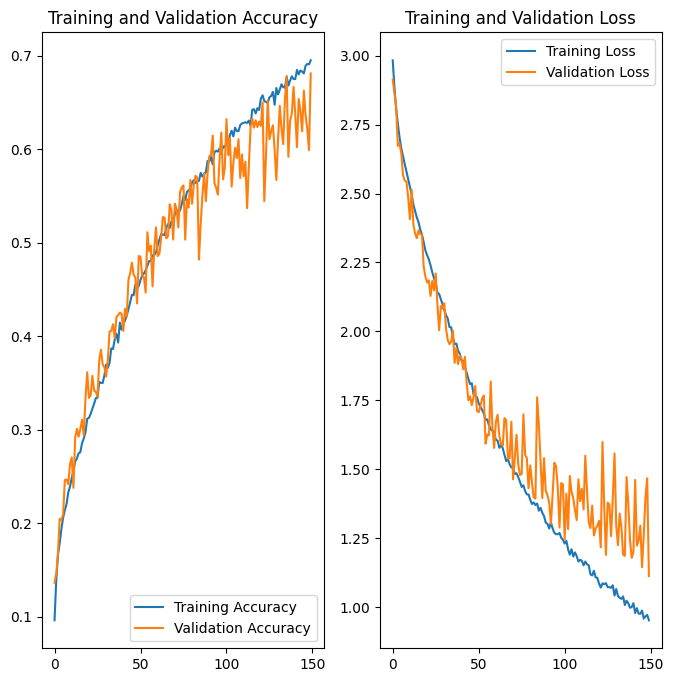

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), acc, label='Training Accuracy')
plt.plot(range(epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Seborrheic Keratoses and other Benign Tumors
2/2 [==============================] - 2s 204ms/step
predicted label: Seborrheic Keratoses and other Benign Tumors


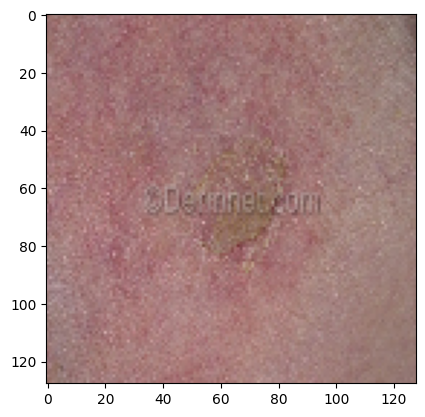

In [43]:
#predictions:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[23].numpy().astype('uint8')
    first_label = labels_batch[25].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[23])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


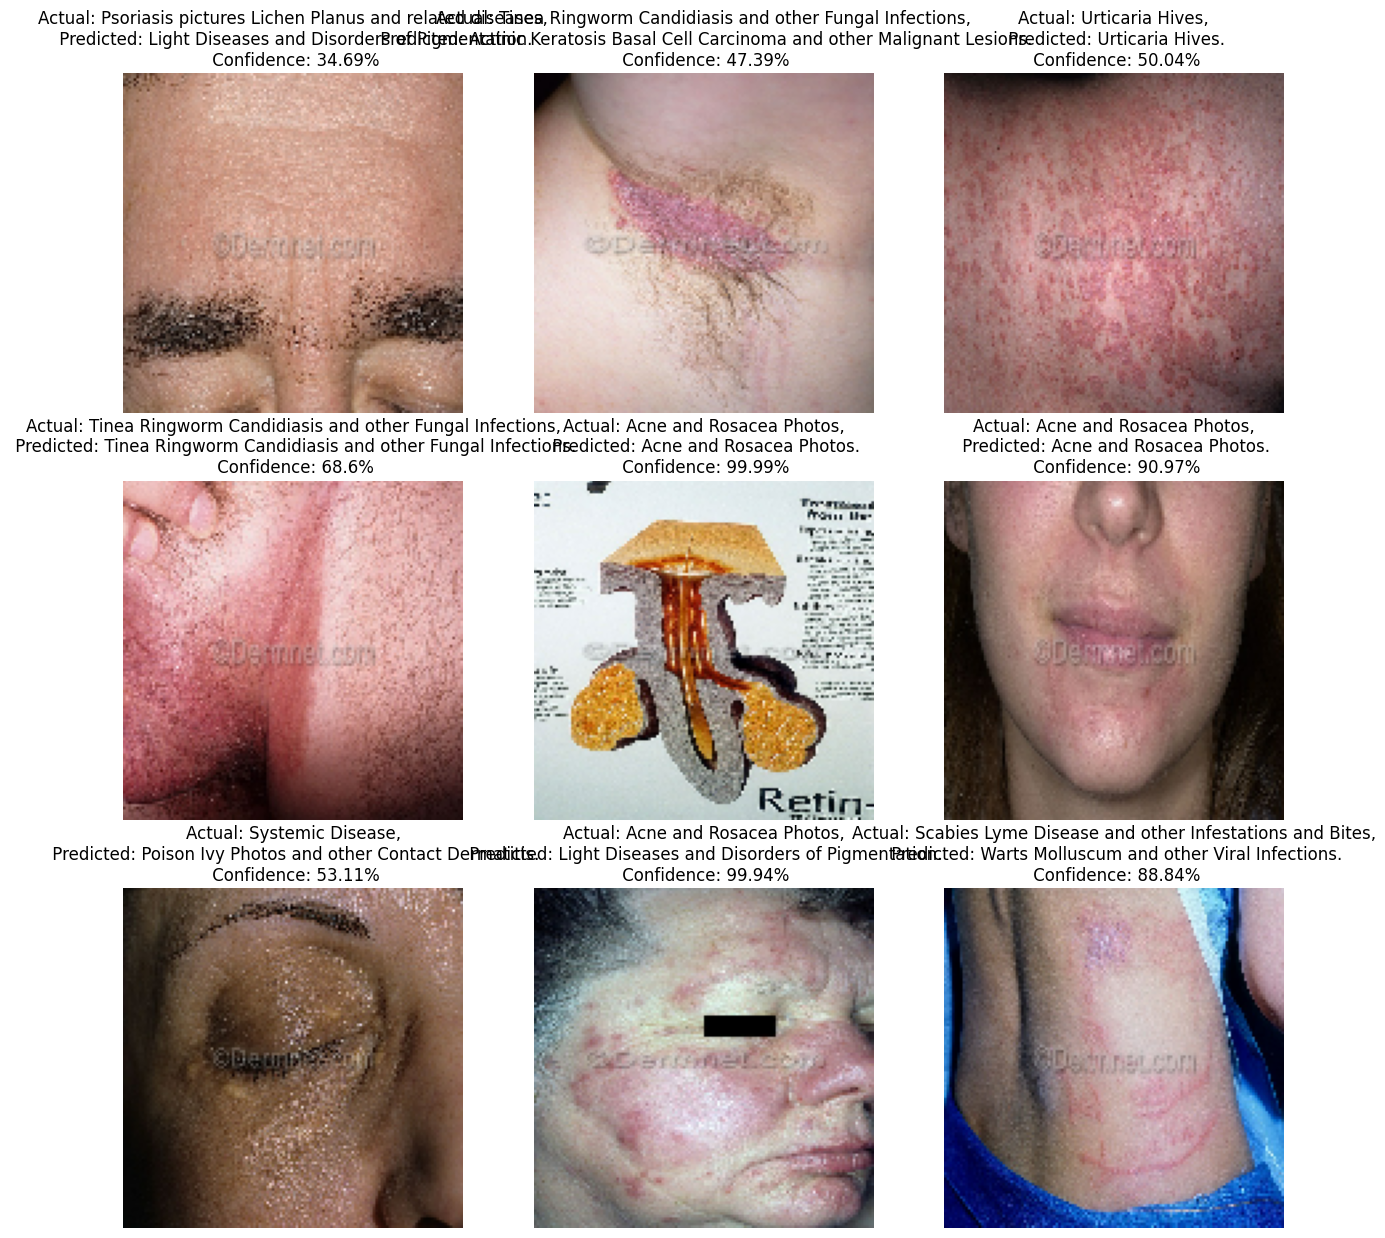

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [51]:
model_version = 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets
